In [1]:
#AGENT

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import math
import pickle
from timeit import default_timer as timer
from datetime import timedelta
import pandas as pd
import numpy as np
import random
from collections import deque
import os

# #set GPU Device
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"



class Agent:
    def __init__(self, state_size,is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.memory1 = deque(maxlen=100)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.history=None
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = model_name if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64,input_dim=self.state_size,activation="relu"))
        model.add(Dense(units=32,activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model

    def act(self, state):
        if not self.is_eval and np.random.rand() <= self.epsilon:            
            return random.randrange(self.action_size)

        options = np.array(self.model.predict((state)))
#         print("Prediction Action From Model ==> ",np.argmax(options[0]))        
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        buffer_size=len(self.memory)
        index = np.random.choice(np.arange(buffer_size), size=batch_size, replace=False).tolist()
        mini_batch = [self.memory[i] for i in index]

        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = np.array(self.model.predict(state))
            target_f[0][action] = target
            self.history=self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 


In [2]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
    vec = []
#     vec1=[]
    lines = open("./" + key + ".csv", "r").read().splitlines()
    for line in lines[1:]:
        vec.append(float(line.split(",")[4]))
#         vec1.append(float(line.split(",")[0]))
    return (vec)

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def softmax(x): 
    e_x = np.exp(x - np.max(x)) 

    return e_x / e_x.sum(axis=0) 

# returns an an n-day state representation ending at time t
def getState(data, t, n):
    d = t - n + 1

    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = []
#     block=block[:-1]
#     res=softmax(np.array(block))
    for i in range(n - 1): 
        res.append(sigmoid(block[i + 1] - block[i]))   
    return np.array([res])


In [ ]:
#train.py
stock_name, window_size, episode_count = "^GSPC", 10,20
data= getStockDataVec(stock_name)
l = len(data) -1
# l=1000
batch_size = 32


agent = Agent(window_size)

EpisodeNo=[]
TotalProfit=[]
No_of_profits=[]
Total_records=[]
history=[]
final_df=pd.DataFrame()

for e in range(episode_count + 1):
    buy=[]
    sell=[]
    profit=[]
    index=[]
    main_df=pd.DataFrame()
    print( "Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []

    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            print( "Buy: " + formatPrice(data[t])+"  index:"+str(t))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            buy.append(bought_price)
            sell.append(data[t])
            profit.append(data[t] - bought_price)
            print( "Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price)+"  index:"+str(t))

        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            main_df['buy']=buy
            main_df['sell']=sell
            main_df['profit']=profit
            path='./output/episode'+str(e)+'.csv'
            main_df.to_csv(path)
            episodeName="model_ep"+str(e)
            EpisodeNo.append(episodeName)
            TotalProfit.append(total_profit)
            No_of_profits.append(len([b for b in profit if b > 0 ]))
            Total_records.append(len(profit))
            print( "--------------------------------")
            print( "Total Profit: " + formatPrice(total_profit))
            print( "--------------------------------")
            history.append(agent.history.history['loss'])
            save_lists={'episode':EpisodeNo,'total_profit':TotalProfit,'loss':history,'epsilon':agent.epsilon}
            pickle_out = open("./pickle_ep/ep_"+str(e)+".pickle","wb")
            pickle.dump(save_lists, pickle_out)
            pickle_out.close()


        if len(agent.memory)>batch_size:
            agent.expReplay(batch_size)

    if e % 1 == 0:
        model_json = agent.model.to_json()
        with open("./models/model_ep"+str(e)+".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        agent.model.save_weights("./models/model_ep"+str(e)+".h5")
        print("Saved model to disk")
        
path='./finaloutput/FinalCalc.csv'
final_df["EpisodeNo"]=EpisodeNo
final_df["TotalProfit"]=TotalProfit
final_df["No_of_profits"]=No_of_profits
final_df["Total_records"]=Total_records
final_df.to_csv(path)        

# plt.figure(figsize=(10, 10))
# plt.plot(EpisodeNo,history)
# plt.xlabel('Episodes')
# plt.ylabel('TotalProfit')
# plt.legend(loc="upper left")



In [41]:
import pickle
import pandas as pd
pickle_in = open("./pickle_ep/ep_13.pickle","rb")
saved=pickle.load(pickle_in)
print(saved["total_profit"])
print(profit_df.shape[0])
profit_df=pd.read_csv("./output/episode2.csv")
print(profit_df[profit_df["profit"]>0].count())
print("profit % :",(profit_df[profit_df["profit"]>0]["profit"].count()/profit_df.shape[0])*100)

[1320.6793949999994, 849.0997429999983, 2278.661808999999, 2215.161810999998, 2112.1005389999996, 657.9114469999981, 1301.030210999999, 2128.141112999999, 1154.1717609999982, 1828.450994999999, 4861.289970999999, -6804.001216999999, 810.5819860000045, 4846.551404000002]
Unnamed: 0    410
buy           410
sell          410
profit        410
dtype: int64
profit % : 62.59541984732825


Loaded model from disk
Buy: $1349.47  index :22
Sell: $1354.31 | Profit: $4.84  index :23
Buy: $1314.76  index :27
Sell: $1330.31 | Profit: $15.55  index :28
Buy: $1153.29  index :59
Sell: $1147.95 | Profit: -$5.34  index :60
Buy: $1219.24  index :127
Sell: $1190.59 | Profit: -$28.65  index :128
Buy: $1207.71  index :136
Sell: $1215.02 | Profit: $7.31  index :137
Buy: $1191.29  index :154
Sell: $1186.73 | Profit: -$4.56  index :155
Buy: $1085.78  index :172
Sell: $1092.54 | Profit: $6.76  index :173
Buy: $1100.64  index :266
Sell: $1113.57 | Profit: $12.93  index :267
Buy: $1083.51  index :272
Sell: $1118.51 | Profit: $35.00  index :277
Buy: $1136.76  index :309
Sell: $1125.40 | Profit: -$11.36  index :310
Buy: $1029.15  index :355
Sell: $1027.53 | Profit: -$1.62  index :356
Buy: $1009.56  index :360
Sell: $1036.17 | Profit: $26.61  index :362
Buy: $937.43  index :407
Sell: $949.36 | Profit: $11.93  index :408
Buy: $879.15  index :418
Sell: $893.92 | Profit: $14.77  index :419
Buy: $91

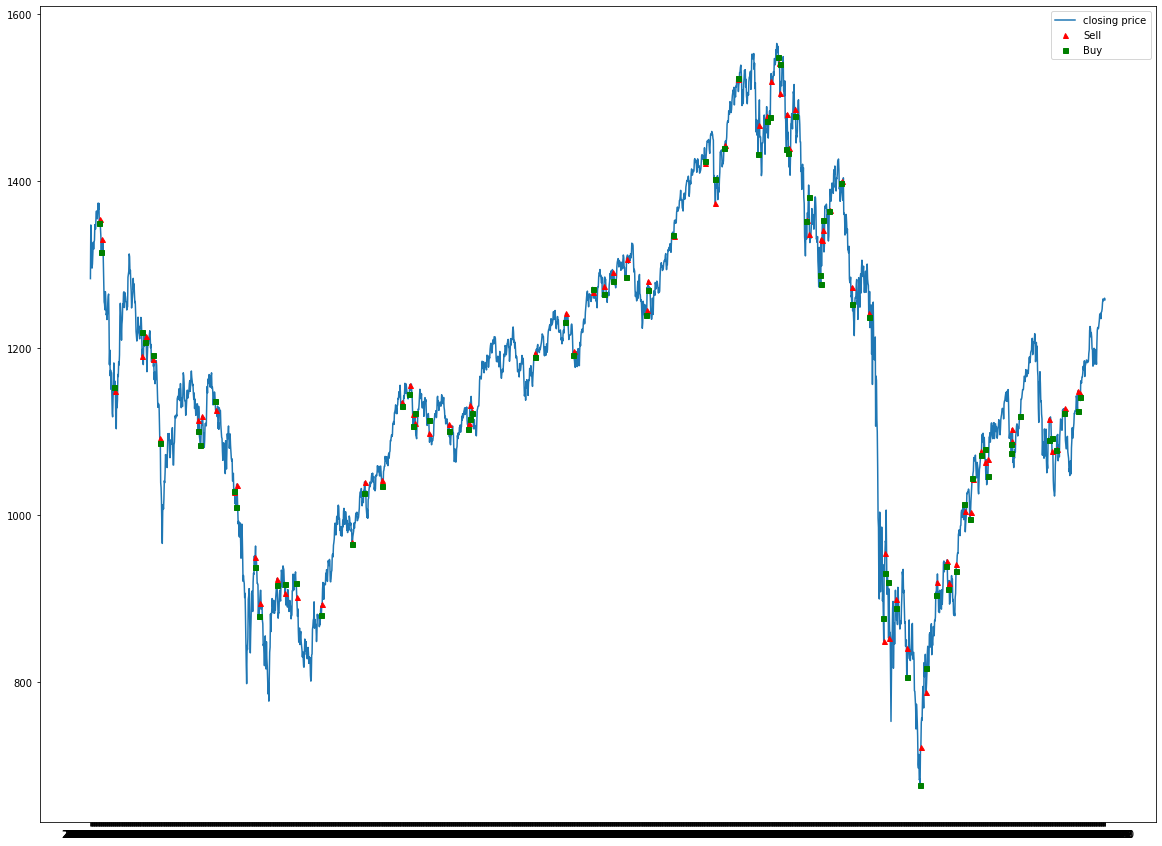

In [13]:
#eval

# load json and create model
modelname="model_ep2"
json_file = open("./models/"+modelname+".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./models/"+modelname+".h5")
print("Loaded model from disk")


stock_name, model_name = "^GSPC", loaded_model
model = loaded_model
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = getStockDataVec(stock_name)
l = len(data) - 1
# l=1000
batch_size = 32

state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
agent.index=[]
buy=[]
sell=[]
profit=[]
main_index=[]
buy_index=[]
sell_index=[]
main_df=pd.DataFrame()
indexes=pd.DataFrame()
for t in range(l):
#     start = dt.datetime.now()
    action = agent.act(state)
    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
        agent.inventory.append(data[t])
        agent.index.append(t)
        print ("Buy: " + formatPrice(data[t])+"  index :"+str(t))
        

    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        b_index = agent.index.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        sell_index.append(t)
        buy_index.append(b_index)
        buy.append(bought_price)
        sell.append(data[t])
        profit.append(data[t] - bought_price)
        main_index.append(t)
#         end=dt.datetime.now()
#         print("---------printing time----------")
#         total_time=end-start
#         ms=total_time.days*24*60*60*1000
#         ms+=total_time.seconds*1000
#         ms+=total_time.microseconds/1000
#         print(ms)
#         print("---------printing time----------")
        print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price)+"  index :"+str(t))

    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        main_df['buy']=buy
        main_df['sell']=sell
        main_df['profit']=profit
        main_df['index']=main_index
        indexes['buy_index']=buy_index
        indexes['sell_index']=sell_index
        path='./output/epi_eval.csv'
        main_df.to_csv(path)
        print ("--------------------------------")
        print (stock_name + " Total Profit: " + formatPrice(total_profit))
        print ("--------------------------------")

final_eval=pd.DataFrame(data=data[:l],columns=["closing_price"])
final_eval.loc[final_eval.index.isin(buy_index),"Action"]="Buy"
final_eval.loc[final_eval.index.isin(sell_index),"Action"]="Sell"
final_eval.fillna("Hold", inplace=True)
final_eval.to_csv("./output/final.csv")        
        
dates=pd.read_csv("^GSPC.csv")[:l]
plt.figure(figsize=(20, 15))
plt.plot(dates['Date'].tolist(),data[:l],label='closing price')
plt.plot(sell_index,sell,'r^',markersize=5,label='Sell')
plt.plot(buy_index,buy,'gs',markersize=5,label='Buy')
plt.legend()
       

In [16]:
print(main_df.shape[0])
print(main_df[main_df["profit"]>0].count()["profit"])
print((main_df[main_df["profit"]>0].count()["profit"]/main_df.shape[0])*100)


87
62
71.26436781609196
